# IMPORTTING LIBRARIES

In [1]:
import tensorflow as tf 
import cv2 as cv
import numpy as np 
from matplotlib import pyplot as plt
import random

2023-09-12 22:43:23.846475: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 22:43:28.603172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 22:43:28.614470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 22:43:47.584733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# IMPORTING DATA

In [76]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.cifar100.load_data()

# ANALYZING AND VISUALIZING THE DATA

In [3]:
train_images.shape

(50000, 32, 32, 3)

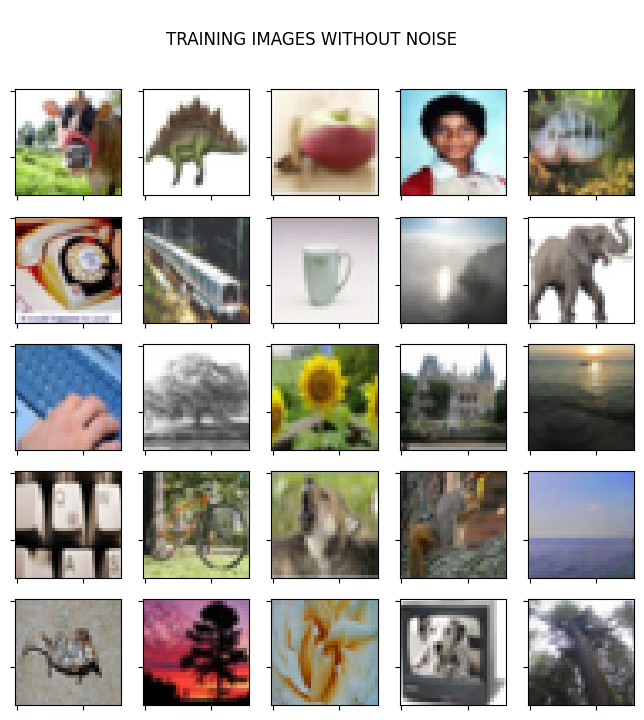

In [4]:
fig,axes = plt.subplots(nrows = 5,ncols = 5,figsize = (8,8))
row=0
col = 0
for i in range(25):
    if i%5==0 and i!=0:
       row+=1
       col = 0
       axes[row][col].imshow(train_images[i])
       axes[row][col].set_xticklabels([])
       axes[row][col].set_yticklabels([])
       col+=1
       continue
    axes[row][col].imshow(train_images[i])
    axes[row][col].set_xticklabels([])
    axes[row][col].set_yticklabels([])
    col+=1
fig.suptitle("\nTRAINING IMAGES WITHOUT NOISE ")
plt.show()

# ADDING NOISE TO MAKE THE DATASET

In [77]:
noise = 0.3
train_noise_images = (train_images/255) + noise*np.random.normal(0,0.3,size = train_images.shape)
train_noise_images = np.clip(train_noise_images,0,1)

## VISUALIZING THE NOISY DATASET 

/tmp/ipykernel_7079/2980776214.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


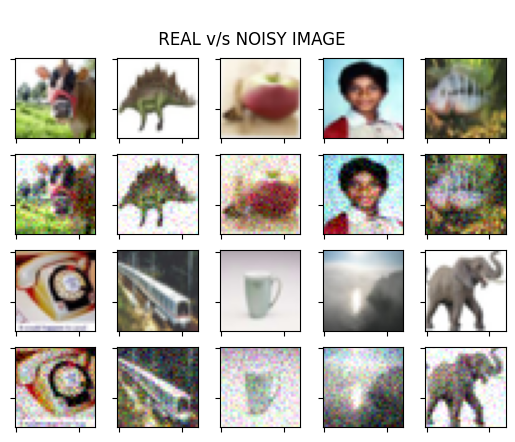

In [6]:
fig,axes = plt.subplots(nrows=4,ncols=5)
row = 0
col = 0
for i in range(10):
    if i == 5 :
        row+=2
        col=0
        axes[row][col].imshow(train_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
        continue
    else:
        axes[row][col].imshow(train_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
col = 0
row = 1
for i in range(10):
    if i == 5 :
        row+=2
        col=0
        axes[row][col].imshow(train_noise_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
        continue
    else:
        axes[row][col].imshow(train_noise_images[i])
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.suptitle("\n REAL v/s NOISY IMAGE \n")
fig.savefig("Data visualzied.png")
fig.show()

## MAKING THE TEST DATASET

In [94]:
test_noisy_images = (test_images/255) + noise*np.random.normal(0,0.3,size=test_images.shape) 
test_noisy_images = np.clip(test_noisy_images,0,1)

In [7]:
def get_data(np_object,shuffle_size,batch_size):
    return tf.data.Dataset.from_tensor_slices(np_object).shuffle(shuffle_size).batch(batch_size)

In [13]:
train_images_noisy = get_data(train_noise_images,train_noise_images.shape[0],32)

2023-09-12 22:53:24.216645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1228800000 exceeds 10% of free system memory.


In [12]:
for image in train_images_noisy.take(1):
    print(image.numpy().shape)

2023-09-12 22:51:54.421872: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1228800000 exceeds 10% of free system memory.


(32, 32, 32, 3)


# MODEL FORMULATION

In [105]:
class autoencoder:
    def __init__(self,shape):
        self.encoder = self.get_encoder(shape)
        self.decoder = self.get_decoder()
        self.model = tf.keras.Sequential(name="auto_encoder")
        self.model.add(self.encoder)
        self.model.add(self.decoder)
    def get_encoder(self,shape,name = "encoder"):
        encoder = tf.keras.Sequential(name=name)
        encoder.add(tf.keras.layers.Input(shape=(shape),name="Input"))
        encoder.add(tf.keras.layers.Conv2D(32,kernel_size=3,activation="relu",padding="same"))
        encoder.add(tf.keras.layers.BatchNormalization())
        encoder.add(tf.keras.layers.MaxPooling2D((2,2)))
        encoder.add(tf.keras.layers.Dropout(0.3))
        encoder.add(tf.keras.layers.Conv2D(32,3,activation="relu",padding="same"))
        encoder.add(tf.keras.layers.LeakyReLU())
        encoder.add(tf.keras.layers.BatchNormalization())
        encoder.add(tf.keras.layers.MaxPooling2D())
        encoder.add(tf.keras.layers.Dropout(0.3))
        encoder.add(tf.keras.layers.Conv2D(64,3,activation="relu",padding="same"))
        encoder.add(tf.keras.layers.MaxPooling2D())
        encoder.add(tf.keras.layers.Flatten())
        return encoder
    def get_decoder(self,name="decoder"):
        decoder = tf.keras.Sequential(name=name)
        decoder.add(tf.keras.layers.Dense(4*4*32))
        decoder.add(tf.keras.layers.Dropout(0.3))
        decoder.add(tf.keras.layers.Reshape(target_shape=(4,4,32)))
        decoder.add(tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=2,padding="same"))
        decoder.add(tf.keras.layers.BatchNormalization())
        decoder.add(tf.keras.layers.Dropout(0.3))
        decoder.add(tf.keras.layers.Conv2DTranspose(32,kernel_size=3,strides=2,padding="same"))
        decoder.add(tf.keras.layers.BatchNormalization())
        decoder.add(tf.keras.layers.Dropout(0.3))
        decoder.add(tf.keras.layers.Conv2DTranspose(3,kernel_size=3,strides=2,padding="same"))
        return decoder
    

In [106]:
auto_encoder = autoencoder((32,32,3))
auto_encoder.model.compile(optimizer="Adam",loss="binary_crossentropy")

In [107]:
auto_encoder.model(np.array([train_noise_images[1]])).shape

TensorShape([1, 32, 32, 3])

In [89]:
auto_encoder.model.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 1024)              28896     
                                                                 
 decoder (Sequential)        (1, 32, 32, 3)            563011    
                                                                 
Total params: 591907 (2.26 MB)
Trainable params: 591587 (2.26 MB)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


In [102]:
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.optimizers import Adam
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model

In [103]:
inputs = Input(shape=(32,32,3))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)
# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 32, 32, 32)           896       ['input_27[0][0]']            
                                                                                                  
 batch_normalization_82 (Ba  (None, 32, 32, 32)           128       ['conv2d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_69 (MaxPooli  (None, 16, 16, 32)           0         ['batch_normalization_82

In [109]:
auto_encoder.model.fit(train_noise_images,train_images/255,epochs=1)

: 

: 

In [97]:
prediction = autoencoder.predict(np.array([test_noisy_images[1]]))

1/1 [==============================] - 0s 17ms/step


In [98]:
prediction.shape

(1, 32, 32, 3)

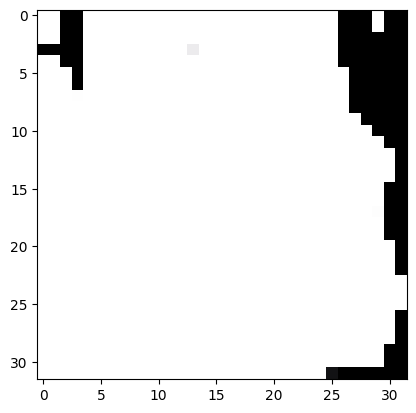

In [100]:
plt.imshow(prediction[0])